<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Data_Sprint_38_The_Kvasir_Capsule_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement
 
Artificial intelligence (AI) is predicted to have profound effects on the future of video capsule endoscopy (VCE) technology.The potential lies in improving anomaly detection while reducing manual labour. However, medical data is often sparse and unavailable to the research community, and qualified medical personnel rarely have time for the tedious labelling work.

## Objective
 

You are required to build a machine learning model to recognize the disease label of the respective images.

## Content
 

The small bowel constitutes the gastrointestinal (GI) tract’s mid-part, situated between the stomach and the large bowel. It is three to four meters long and has a surface of about 30 m^2, including the surface of the villi, and plays a crucial role in absorbing nutrients. Therefore, disorders in the small bowel may cause severe growth retardation in children and nutrient deﬁciencies in children and adults. 

This organ may be affected by 
**chronic diseases**, like 
* Crohn’s disease, 
* coeliac disease, and 
* angiectasis

or  **malignant diseases** like 
* lymphoma and 
* adenocarcinoma. 

These diseases may represent a substantial health challenge for both patients and society, and a thorough examination of the lumen is frequently necessary to diagnose and treat them. However, the small bowel, due to its anatomical location, is less accessible for inspection by ﬂexible endoscopes commonly used for the upper GI tract and the large bowel. Since early 2000, video capsule endoscopy (VCE) has been used, usually as a complementary test for patients with GI bleeding. 

A VCE consists of a small capsule containing a wide-angle camera, lightsources, batteries, and other electronics. The patient swallows the capsule, which then captures a video as it moves passively through the GI tract. A recorder, carried by the patient or included in the capsule, stores the video before a medical expert assesses it after the procedure. 

[Source of information: Reasearch paper: Kvasir-Capsule, a video capsule endoscopy dataset]

## Mount Drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Download the images

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1yDcNMTI-8Zq2Mvs8qe7pLNpPx4BW5Yta',
dest_path='/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule.zip',unzip=True)

Unzipping...Done.


## Import Data Science packages

In [2]:
#changing filename to paths
import os
import pandas as pd
import numpy as np
import PIL
import cv2
#
import seaborn as sns
import matplotlib.pyplot as plt
#
import warnings
warnings.filterwarnings("ignore")
#
%matplotlib inline

## Import Data

In [3]:
train_data = pd.read_csv("/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/Training_set.csv")
test_data = pd.read_csv("/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/Testing_set.csv")

In [4]:
train_data.head()

filename                label
0  Image_1.jpg  Normal clean mucosa
1  Image_2.jpg  Normal clean mucosa
2  Image_3.jpg         Foreign body
3  Image_4.jpg  Normal clean mucosa
4  Image_5.jpg  Normal clean mucosa

In [5]:
train_data.shape

(37790, 2)

In [6]:
test_data.head()

filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg

In [7]:
test_data.shape

(9448, 1)

## Unique Labels

In [8]:
labels = train_data['label'].unique().tolist()
labels

['Normal clean mucosa',
 'Foreign body',
 'Reduced mucosal view',
 'Ileocecal valve',
 'Lymphangiectasia',
 'ulcer',
 'Angiectasia',
 'Pylorus',
 'Erosion',
 'Blood - fresh',
 'Erythema',
 'Polyp',
 'ampulla_of_vater',
 'Blood - hematin']

## Add the complete path for the training images

In [4]:
paths = [os.path.join("/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train", x) for x in train_data['filename']]
test_paths = [os.path.join("/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/test", x) for x in test_data['filename']]

In [5]:
train_data['image_path'] = paths
test_data['image_path'] = test_paths

train_data.drop(['filename'], axis = 1, inplace=True)
test_data.drop(['filename'], axis = 1, inplace=True)

In [6]:
file_paths = train_data.image_path.values.tolist()
labels = train_data.label.values.tolist()

In [7]:
train_data.head()

label                                         image_path
0  Normal clean mucosa  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...
1  Normal clean mucosa  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...
2         Foreign body  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...
3  Normal clean mucosa  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...
4  Normal clean mucosa  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...

In [8]:
train_data = train_data[['image_path','label']]
train_data.head()

image_path                label
0  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...  Normal clean mucosa
1  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...  Normal clean mucosa
2  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...         Foreign body
3  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...  Normal clean mucosa
4  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...  Normal clean mucosa

In [9]:
test_data.head()

image_path
0  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...
1  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...
2  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...
3  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...
4  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...

## Check if Image files are empty

In [11]:
img_list  = train_data.image_path.values.tolist()
empty_images = []
empty_index = []
for i,img in enumerate(img_list):
  if os.stat(img).st_size == 0:
    try:
      empty_images.append(img)
      empty_index.append(i)
    except:
      pass

In [12]:
len(empty_images)

14

In [13]:
train_data.shape

(37790, 2)

In [14]:
train_data = train_data[~train_data['image_path'].isin(empty_images)]
train_data.shape

(37776, 2)

In [15]:
train_new = train_data.copy()

In [16]:
def imagename(x):
  return x.split("/")[-1]
train_new['image_path'] = train_new['image_path'].apply(lambda x : imagename(x))

In [17]:
train_new.head()

image_path                label
0  Image_1.jpg  Normal clean mucosa
1  Image_2.jpg  Normal clean mucosa
2  Image_3.jpg         Foreign body
3  Image_4.jpg  Normal clean mucosa
4  Image_5.jpg  Normal clean mucosa

In [29]:
train_new.to_csv('/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/Train_filtered.csv',index=False)

## Fastai

In [18]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
#from fastai.callbacks.hooks import *
from fastai.callbacks import *
#
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
#
import warnings
warnings.filterwarnings('ignore')

In [19]:
path ='/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/'
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0,do_flip=False,xtra_tfms=[cutout()])
data = (ImageList.from_csv(path, csv_name = '/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/Train_filtered.csv')
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/test')              
        .transform(tfms, size=400)
        .databunch(num_workers=0,bs=8))

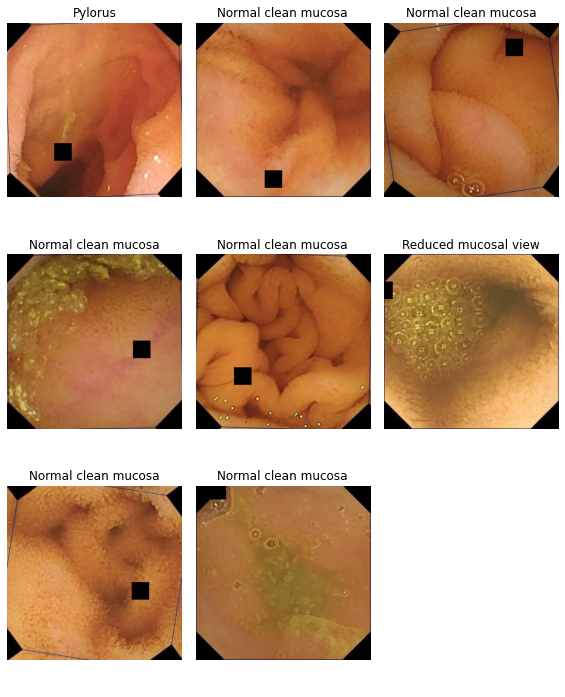

In [31]:
data.show_batch(rows=3, figsize=(8,10))

In [21]:
## print the target classes
val=data.classes
print(f"The number of target class : {data.c} and the respective target classes are a: {data.classes}")

The number of target class : 14 and the respective target classes are a: ['Angiectasia', 'Blood - fresh', 'Blood - hematin', 'Erosion', 'Erythema', 'Foreign body', 'Ileocecal valve', 'Lymphangiectasia', 'Normal clean mucosa', 'Polyp', 'Pylorus', 'Reduced mucosal view', 'ampulla_of_vater', 'ulcer']


##Define F1 metrics

In [20]:
fscore = FBeta(average='macro', beta=2.0)

## Set Path

In [22]:
path= '/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/'
k= '/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/Train_filtered.csv'
p ='/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/Testing_set.csv'
#
train=pd.read_csv(k)
test=pd.read_csv(p)

In [23]:
np.random.seed(1786)
ROOT = "/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/"

In [24]:
def read_data(root):
    train_df = pd.read_csv(k)
    test_df = pd.read_csv(p)
    return train_df, test_df

## Define Callback

In [25]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc,f1 = metrics[0], metrics[1],metrics[2]
        if (self.best_acc is None) or (acc > self.best_acc) or (loss < self.best_loss):
            self.best_acc = acc
            self.best_loss = loss
            self.best_f1 = f1
            self.learn.save(f'{self.name}')
            print("Save the best acc {:.5f}".format(self.best_acc))
            print("Save the best f1 {:.5f}".format(self.best_f1))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Acc is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

## Perform Training Validation and Evaluation using Densenet121 model with Cross_Validation

(37776, 2) (9448, 1)
Starting fold 0
(35415,) (2361,)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


Better model found at epoch 0 with error_rate value: 0.017789073288440704.


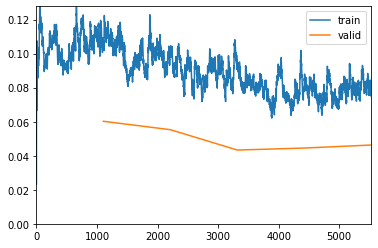

Better model found at epoch 2 with error_rate value: 0.015247776173055172.
Better model found at epoch 3 with error_rate value: 0.013553579337894917.


Better model found at epoch 0 with error_rate value: 0.014400677755475044.


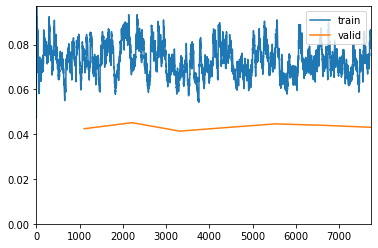

Better model found at epoch 1 with error_rate value: 0.013977128081023693.
Better model found at epoch 2 with error_rate value: 0.013130029663443565.


Better model found at epoch 0 with error_rate value: 0.15501905977725983.


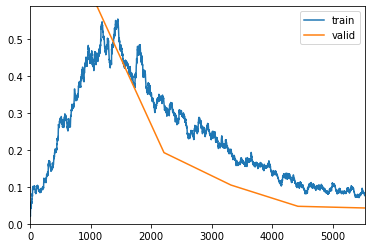

Better model found at epoch 1 with error_rate value: 0.06522659957408905.
Better model found at epoch 2 with error_rate value: 0.03176620230078697.
Better model found at epoch 3 with error_rate value: 0.014824227429926395.
Better model found at epoch 4 with error_rate value: 0.011435831896960735.


F1 score for this fold  0.9850640931747902


In [26]:
if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(1):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT,folder="train").split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=ResizeMethod.SQUISH).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        learn = cnn_learner(data, models.densenet121, metrics=[error_rate,accuracy,fscore], ps=0.5)
        #learn = cnn_learner(data, models.densenet201, metrics=[error_rate,accuracy,fscore], ps=0.5)
        cb =[SaveModelCallback(learn,monitor="error_rate",mode="min",name="bestmodel_{}".format(i)),
                               ShowGraph(learn),EarlyStoppingCallback(learn, min_delta=1e-5, patience=5),]
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(5)
        learn.unfreeze()
        #learn.fit_one_cycle(10, max_lr=1e-4, callbacks=cb)
        #learn.fit_one_cycle(10, max_lr=5e-5, callbacks=cb)
        learn.fit_one_cycle(5, max_lr=1e-5, callbacks=cb)
        #learn.fit_one_cycle(10, max_lr=5e-6, callbacks=cb)
        learn.fit_one_cycle(7, max_lr=1e-6, callbacks=cb)
        learn.fit_one_cycle(5, max_lr=1e-3, callbacks=cb)
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)

## Confusion Matrix

In [41]:
interp = ClassificationInterpretation.from_learner(learn)

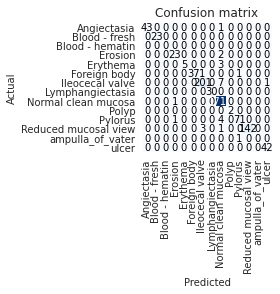

In [43]:
interp.plot_confusion_matrix()

In [42]:
interp.confusion_matrix()

array([[ 43,   0,   0,   0, ...,   0,   0,   0,   0],
       [  0,  23,   0,   0, ...,   0,   0,   0,   0],
       [  0,   0,   0,   0, ...,   0,   0,   0,   0],
       [  0,   0,   0,  23, ...,   0,   0,   0,   0],
       ...,
       [  0,   0,   0,   1, ...,  71,   0,   0,   0],
       [  0,   0,   0,   0, ...,   0, 142,   0,   0],
       [  0,   0,   0,   0, ...,   1,   0,   0,   0],
       [  0,   0,   0,   0, ...,   0,   0,   0,  42]])

## Plot Top 9 Losses

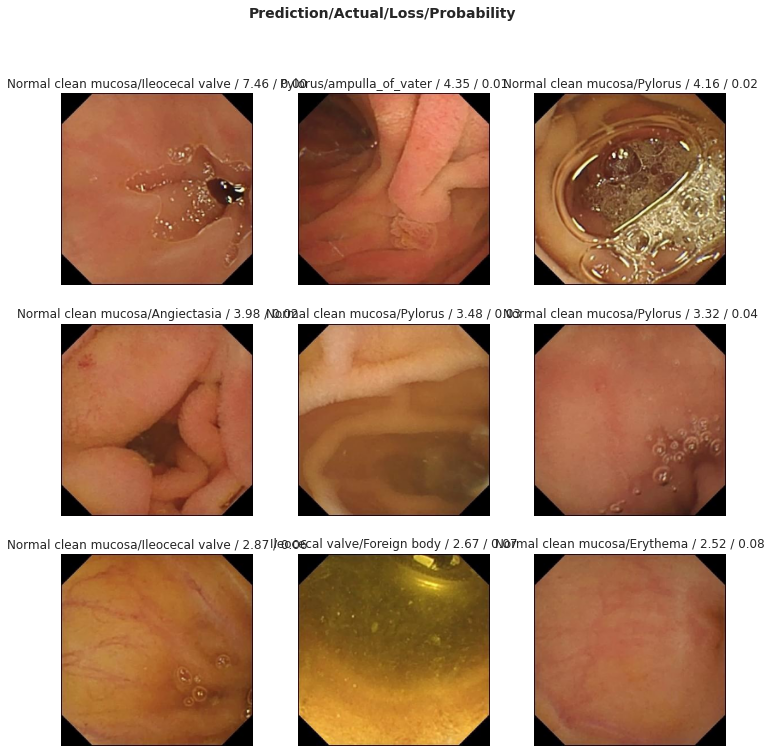

In [49]:
interp.plot_top_losses(9)

In [46]:
losses,idxs = interp.top_losses()

In [47]:
losses,idxs

(tensor([7.4649, 4.3467, 4.1609,  ..., -0.0000, -0.0000, -0.0000]),
 tensor([ 263, 2360,  206,  ..., 1833,  851, 1353]))

## Make Predictions on test data

In [27]:
test_data["label"] = np.argmax(test_preds, axis=1)

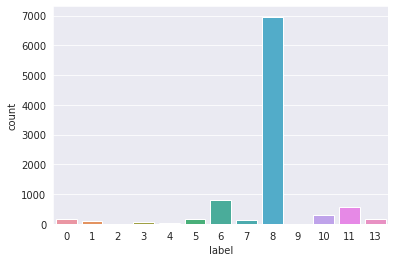

In [28]:
sns.set_style('darkgrid')
sns.countplot(x='label',data=test_data)
plt.show()

In [29]:
val

['Angiectasia',
 'Blood - fresh',
 'Blood - hematin',
 'Erosion',
 'Erythema',
 'Foreign body',
 'Ileocecal valve',
 'Lymphangiectasia',
 'Normal clean mucosa',
 'Polyp',
 'Pylorus',
 'Reduced mucosal view',
 'ampulla_of_vater',
 'ulcer']

## Prepare Label Mapper

In [36]:
val_mapper = {k:v for k,v in enumerate(val)}

In [37]:
val_mapper

{0: 'Angiectasia',
 1: 'Blood - fresh',
 2: 'Blood - hematin',
 3: 'Erosion',
 4: 'Erythema',
 5: 'Foreign body',
 6: 'Ileocecal valve',
 7: 'Lymphangiectasia',
 8: 'Normal clean mucosa',
 9: 'Polyp',
 10: 'Pylorus',
 11: 'Reduced mucosal view',
 12: 'ampulla_of_vater',
 13: 'ulcer'}

In [30]:
sub = pd.read_csv("/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/sample_submission.csv")
sub.head()

filename                label
0  Image_1.jpg  Normal clean mucosa
1  Image_2.jpg  Normal clean mucosa
2  Image_3.jpg  Normal clean mucosa
3  Image_4.jpg  Normal clean mucosa
4  Image_5.jpg  Normal clean mucosa

In [32]:
test_data.head()

image_path  label
0  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...      8
1  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...      8
2  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...      8
3  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...      6
4  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...      8

In [33]:
test.shape,test_data.shape

((9448, 1), (9448, 2))

In [38]:
test['label'] = test_data['label'].map(val_mapper)

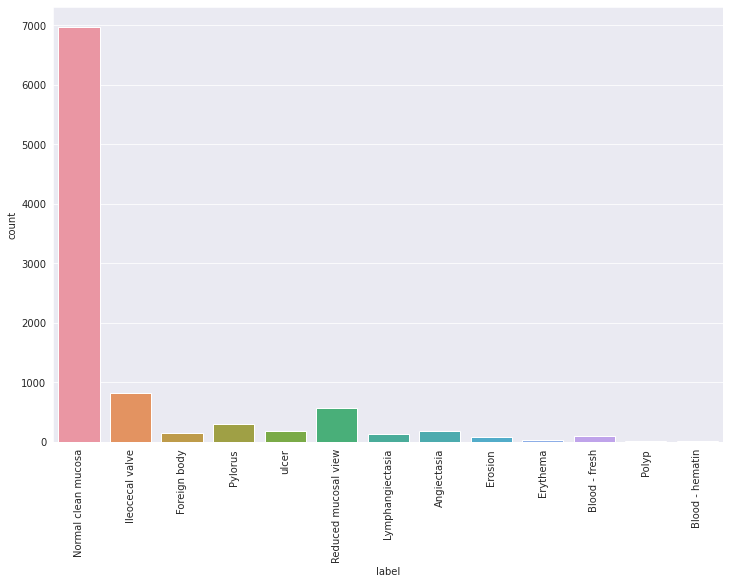

In [39]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.xticks(rotation=90)
sns.countplot(x='label',data=test)
plt.show()

In [40]:
test.to_csv('kvasir_densenet121.csv',index=False)

**Submission successful! Your score is 98.29602608759077.**

## end Fastai

## Function to preproces images

In [ ]:
def preProcess_Image(image):
  img = cv2.imread(image)
  img = cv2.resize(img, (224, 224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
  img = cv2.equalizeHist(img[:, :, 0])
  #img = cv2.Canny(img, 80, 100)
  #kernel = np.ones((5, 5), np.uint8)
  #img = cv2.erode(img, kernel, iterations=3)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Function to display the images

In [ ]:
def show_image(image,label):
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,10))
  orig_img = cv2.imread(image)
  orig_img = cv2.resize(orig_img, (224, 224))
  processed_img =  preProcess_Image(image)
  ax1.imshow(orig_img)
  ax2.imshow(processed_img)
  ax1.set_title(f'Original Image {label}')
  ax2.set_title(f'Processed Image {label}')

##Shape of the images after preprocessing

In [ ]:
preProcess_Image(file_paths[i]).shape

(224, 224, 3)

## Display Random  Training Images

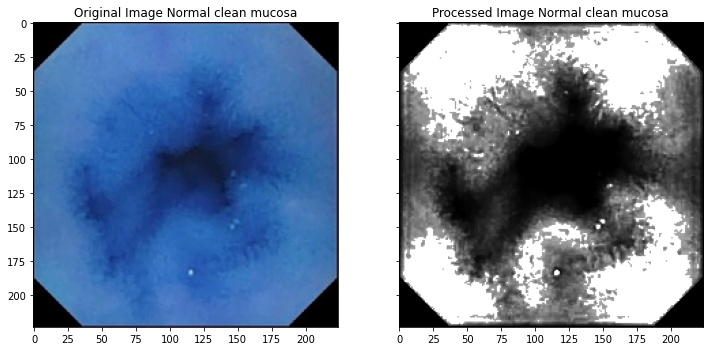

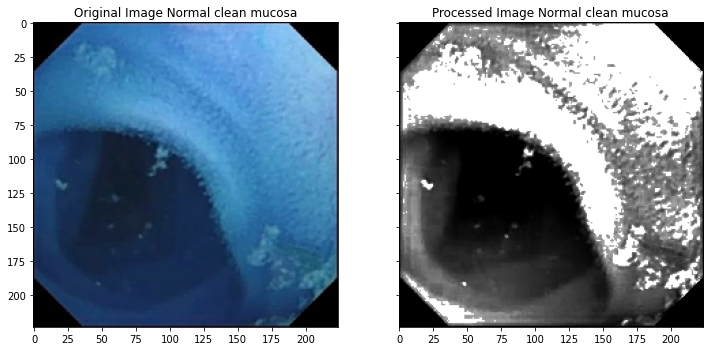

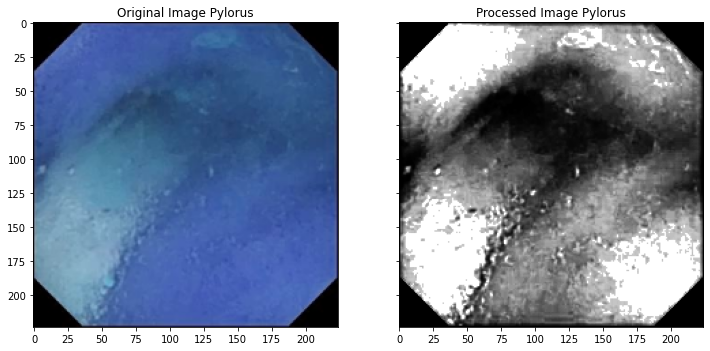

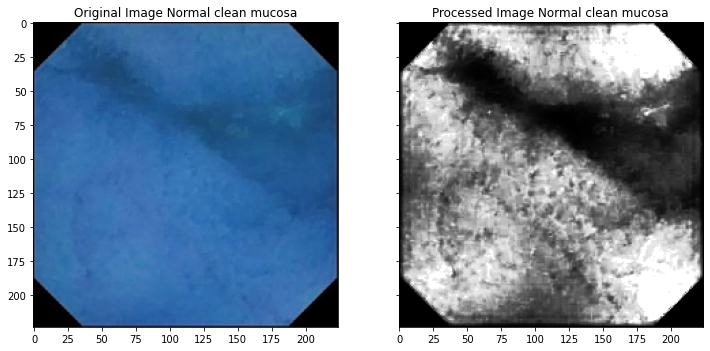

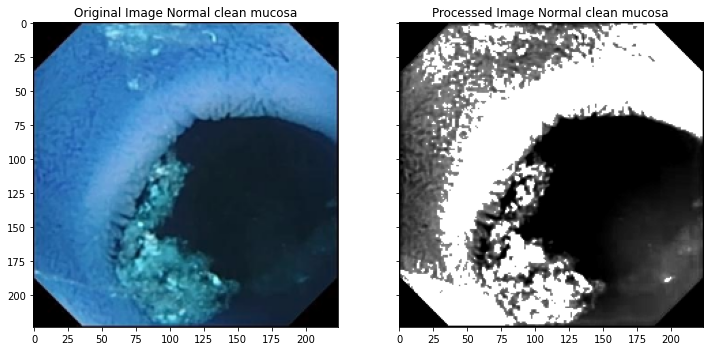

In [ ]:
for i in range(5):
  i = np.random.randint(1000,2000)
  show_image(file_paths[i],labels[i])

## Visualize Test Images

In [ ]:
def show_test_image(image):
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,10))
  orig_img = cv2.imread(image)
  orig_img = cv2.resize(orig_img, (224, 224))
  processed_img =  preProcess_Image(image)
  ax1.imshow(orig_img)
  ax2.imshow(processed_img)
  ax1.set_title(f'Original Test Image')
  ax2.set_title(f'Processed Test Image')

In [ ]:
test_images = test_data.image_path.values.tolist()

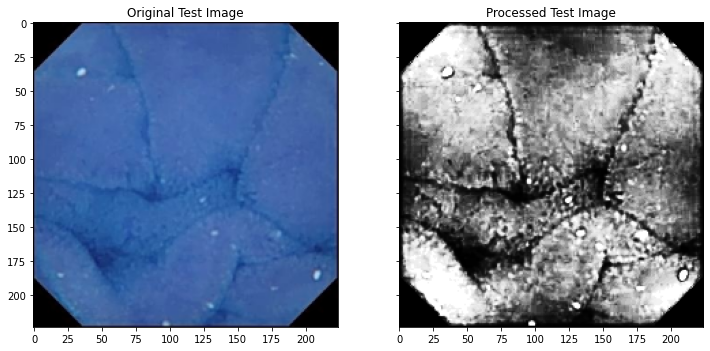

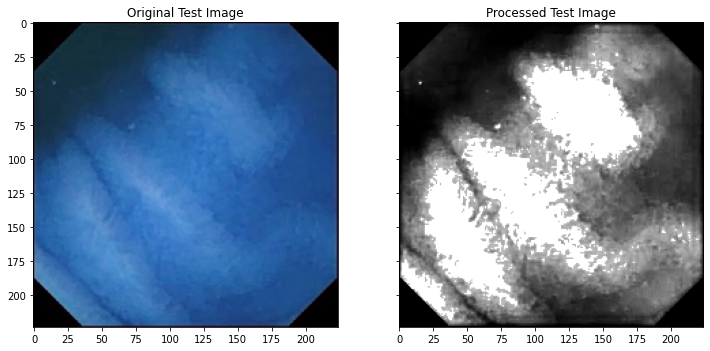

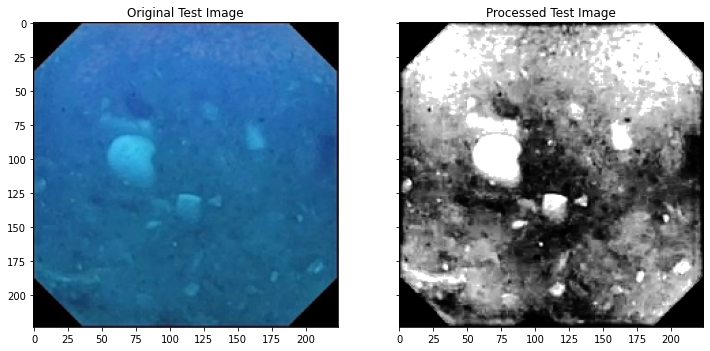

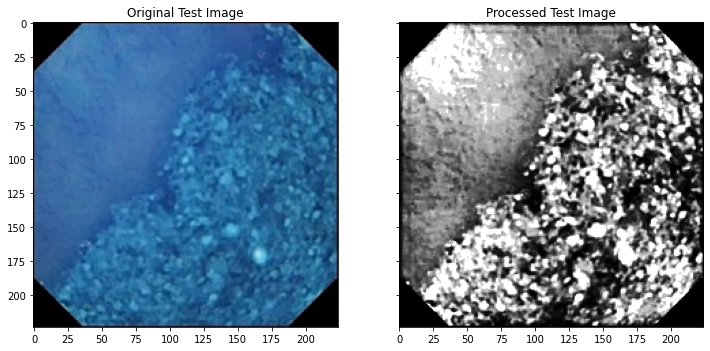

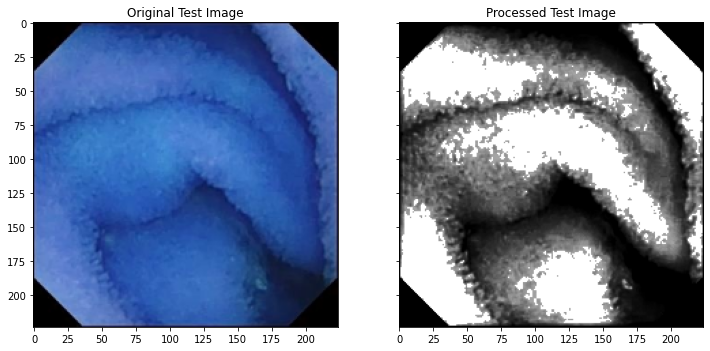

In [ ]:
for i in range(5):
  i = np.random.randint(1000,2000)
  show_test_image(test_images[i])

## Distribution of labels

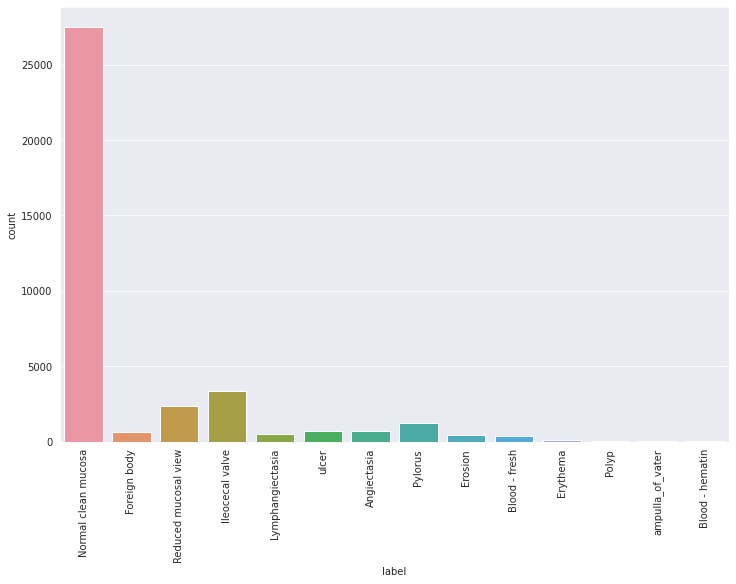

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.xticks(rotation =90)
sns.countplot(train_data.label)

## Count of each label

In [ ]:
train_data.label.value_counts()

Normal clean mucosa     27470
Ileocecal valve          3351
Reduced mucosal view     2325
Pylorus                  1223
Angiectasia               693
ulcer                     683
Foreign body              621
Lymphangiectasia          473
Erosion                   405
Blood - fresh             357
Erythema                  127
Polyp                      44
Blood - hematin            10
ampulla_of_vater            8
Name: label, dtype: int64

## Trian Test Split

In [ ]:
from sklearn.model_selection import train_test_split
train_set,val_set= train_test_split(train_data,test_size=0.1,stratify=train_data['label'],random_state=42)

In [ ]:
train_set.shape,val_set.shape

((34011, 2), (3779, 2))

In [ ]:
train_set.to_csv("/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/Training_split.csv",index=False)
val_set.to_csv("/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/validation_split.csv",index=False)

In [ ]:
train_set.head()

image_path                label
36036  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...  Normal clean mucosa
471    /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...  Normal clean mucosa
4195   /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...  Normal clean mucosa
6903   /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...  Normal clean mucosa
37061  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...      Ileocecal valve

## Make Folders for each images

In [ ]:
Root = "/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/"
new_folder = "TRAIN"
val_folder = "VAL"
_dir = os.path.join(Root,val_folder)

In [ ]:
_dir

'/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/VAL'

In [ ]:
os.path.exists(_dir)

False

In [ ]:
if not os.path.exists(_dir):
    os.makedirs(_dir)

In [ ]:
target_folders = ['TRAIN','VAL']

In [ ]:
for f in target_folders:
  for label in labels:
    _dir = os.path.join(Root,f,label)
    if not os.path.exists(_dir):
      os.makedirs(_dir)

## Copy Training images to respective folders

In [ ]:
import shutil
from tqdm import tqdm
for data in tqdm(train_data.values.tolist()):
  images = data[0]
  lbls = data[1]
  dest = os.path.join(Root,'TRAIN',lbls)
  if os.stat(images).st_size != 0:
    shutil.copy(images,dest)


100%|██████████| 37790/37790 [5:04:43<00:00,  2.07it/s]


## Copy Validation data into respective folders

In [ ]:
import shutil
from tqdm import tqdm
for data in tqdm(val_set.values.tolist()):
  images = data[0]
  lbls = data[1]
  dest = os.path.join(Root,'VAL',lbls)
  if os.stat(images).st_size != 0:
    shutil.copy(images,dest)

## Apply Startified kfolds to handle imbalanced dataset

In [ ]:
from sklearn.model_selection import StratifiedKFold
dfx = train_data.copy()
#assign default value to fold
dfx["kfold"] = -1

# Shuffle data
dfx = dfx.sample(frac=1).reset_index(drop=True)

kf = StratifiedKFold(n_splits=5)

for fold, (trn_, val_) in enumerate(kf.split(X=dfx, y=dfx.label.values)):
    print(len(trn_), len(val_))
    dfx.loc[val_, 'kfold'] = fold


30232 7558
30232 7558
30232 7558
30232 7558
30232 7558


In [ ]:
dfx.head()

label  ... kfold
0  Normal clean mucosa  ...     0
1  Normal clean mucosa  ...     0
2      Ileocecal valve  ...     0
3  Normal clean mucosa  ...     0
4  Normal clean mucosa  ...     0

[5 rows x 3 columns]

In [ ]:
dfx.kfold.value_counts()

4    7558
3    7558
2    7558
1    7558
0    7558
Name: kfold, dtype: int64

In [ ]:
dfx.to_csv("/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train_set_folds.csv",index=False)

## Start of Pytorch Lightning Flash


In [ ]:
!pip install pytorch-lightning

  Found existing installation: pyDeprecate 0.3.2
    Uninstalling pyDeprecate-0.3.2:
      Successfully uninstalled pyDeprecate-0.3.2


In [ ]:
! pip install git+https://github.com/PyTorchLightning/lightning-flash.git

  Cloning https://github.com/PyTorchLightning/lightning-flash.git to /tmp/pip-req-build-mmkimiqr
  Running command git clone -q https://github.com/PyTorchLightning/lightning-flash.git /tmp/pip-req-build-mmkimiqr
  Created wheel for lightning-flash: filename=lightning_flash-0.4.1.dev0-cp37-none-any.whl size=225795 sha256=5573d29656df4577c826a54d6829f9a042281edb156d26a2b086ae2372b45bab
  Stored in directory: /tmp/pip-ephem-wheel-cache-34qt6uuf/wheels/91/2d/5d/a5c188ff0462566709ba09d64e4f051cfa6cf2714ebefa1c77
Successfully built lightning-flash


In [ ]:
import flash
from flash.core.data.utils import download_data
from flash.image import ImageClassificationData, ImageClassifier
print(flash.__version__)#0.2.1
#
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint,EarlyStopping

print(pl.__version__)#
#
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

0.4.1dev
1.3.7


In [ ]:
!pip install fiftyone

     |████████████████████████████████| 2.3MB 12.5MB/s 
     |████████████████████████████████| 225kB 36.1MB/s 
     |████████████████████████████████| 573kB 36.9MB/s 
     |████████████████████████████████| 133kB 44.4MB/s 
     |████████████████████████████████| 563kB 38.1MB/s 
     |████████████████████████████████| 79.9MB 100kB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 29.3MB 195kB/s 
     |████████████████████████████████| 36.7MB 94kB/s 
     |████████████████████████████████| 19.1MB 178kB/s 
     |████████████████████████████████| 112kB 42.7MB/s 
     |████████████████████████████████| 194kB 41.0MB/s 
     |████████████████████████████████| 7.6MB 30.6MB/s 
     |████████████████████████████████| 81kB 10.2MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 143kB 43.1MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
 

In [ ]:
# 2. Load the data
datamodule = ImageClassificationData.from_csv(
    input_fields = 'image_path',
    target_fields = 'label',
    train_file ="/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/Training_split.csv",
    val_file= "/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/validation_split.csv",)
    

ModuleNotFoundError: ignored

## End of Pytorch Lightning Flash


## Building a classification module using pytorch lightning

In [ ]:
!pip install pytorch-lightning

     |████████████████████████████████| 819kB 4.1MB/s 
     |████████████████████████████████| 829kB 12.7MB/s 
     |████████████████████████████████| 645kB 17.6MB/s 
     |████████████████████████████████| 112kB 30.8MB/s 
     |████████████████████████████████| 10.6MB 17.3MB/s 
     |████████████████████████████████| 276kB 36.9MB/s 
     |████████████████████████████████| 1.3MB 33.2MB/s 
     |████████████████████████████████| 143kB 40.6MB/s 
     |████████████████████████████████| 296kB 37.0MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=6ff849b31009ae51c09cb800c0898d86aef9662f55b02e93dc7e465ce7a74dca
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully

In [ ]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 4.2MB/s 
     |████████████████████████████████| 952kB 7.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65175 sha256=bb388c4452f715bc2f98b8c44b5f1c1b20d2903d1b7f77b5e92c5141481cbef8
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
!pip install timm

     |████████████████████████████████| 348kB 4.1MB/s 


In [ ]:
import os
import albumentations
from albumentations.pytorch import ToTensorV2
#
import pandas as pd
import numpy as np
#
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import models
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.transforms import transforms
#
from sklearn import metrics, model_selection, preprocessing
#
import PIL
from PIL import Image
from PIL import ImageFilter

#

import timm

import pytorch_lightning as pl

from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor, BackboneFinetuning
# from pytorch_lightning.loggers import NeptuneLogger


import torchmetrics as tm

import warnings
warnings.filterwarnings('ignore')

from google.colab.patches import cv2_imshow

## Visualize the list of pretrained models available in timm

In [ ]:
timm.list_models()

['adv_inception_v3',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'cspdarknet53',
 'cspdarknet53_iabn',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'darknet53',
 'densenet121',
 'densenet121d',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264',
 'densenet264d_iabn',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'eca_nfnet_l0',
 'eca_nfnet_l1',
 'eca_vovnet39b',
 'ecaresnet26t'

## Define Configurations

In [ ]:
train_images = "/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train"
test_images = "/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/test"
drive_path = "/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule"
#
trainset = "/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train_set_folds.csv"
#
model_folder = "/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/models"
#
#model_name = "xception65"
model_name =  "densenet121"
pretrained = True
#
num_classes = 14
#
virtual_batch_size = 32
batch_size_train = 32
batch_size_val = 32
use_preprocess = True
#use_preprocess = False

max_epochs = 30
lr = 1e-4
weight_decay = 1e-3

nfolds = 5



In [ ]:
batch_size_val 

32

In [ ]:
train_data = pd.read_csv(trainset)
dfx = train_data.copy()

In [ ]:
dfx.head()

label  ... kfold
0  Normal clean mucosa  ...     0
1  Normal clean mucosa  ...     0
2      Ileocecal valve  ...     0
3  Normal clean mucosa  ...     0
4  Normal clean mucosa  ...     0

[5 rows x 3 columns]

In [ ]:
def f(r):
  if r == "ampulla_of_vater":
      return 0
  elif r == "Angiectasia":
      return 1
  elif r == "Blood - fresh":
      return 2
  elif r == "Blood - hematin":
      return 3
  elif r == "Erosion":
      return 4
  elif r == "Erythema":
      return 5
  elif r == "Foreign body":
      return 6
  elif r == "Ileocecal valve":
      return 7
  elif r == "Lymphangiectasia":
      return 8
  elif r == "Normal clean mucosa":
      return 9
  elif r == "Polyp":
      return 10
  elif r == "Pylorus":
      return 11
  elif r == "Reduced mucosal view":
      return 12
  else:
      return 13

In [ ]:
dfx['label'] = dfx['label'].apply(f)
dfx.head()

label                                         image_path  kfold
0      9  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...      0
1      9  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...      0
2      7  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...      0
3      9  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...      0
4      9  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...      0

In [ ]:
print(f"Number of labels = {dfx.label.nunique()}")

Number of labels = 14


##Check if certain .jpg files are empty


In [ ]:
img_list  = dfx.image_path.values.tolist()
empty_images = []
empty_index = []
for i,img in enumerate(img_list):
  if os.stat(img).st_size == 0:
    try:
      empty_images.append(img)
      empty_index.append(i)
    except:
      pass

In [ ]:
empty_images

['/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/Image_23443.jpg',
 '/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/Image_23447.jpg',
 '/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/Image_23442.jpg',
 '/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/Image_23444.jpg',
 '/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/Image_23446.jpg',
 '/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/Image_15616.jpg',
 '/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/Image_23440.jpg',
 '/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/Image_23441.jpg',
 '/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/Image_23445.jpg',
 '/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/Image_23449.jpg',
 '/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/Image_23448.jpg',
 '/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/Image_15615.jpg',
 '/content/drive/MyDrive/dphi/Kvasir/The

In [ ]:
preProcess_Image("'/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/Image_15615.jpg'")

error: ignored

In [ ]:
plt.imshow(PIL.Image.open("'/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train/Image_15617.jpg'"))

FileNotFoundError: ignored

In [ ]:
empty_index

[822,
 3957,
 12925,
 17125,
 17355,
 18074,
 19546,
 21053,
 24862,
 26938,
 29698,
 32821,
 35500,
 36382]

In [ ]:
dfx.shape

(37790, 3)

In [ ]:
dfx = dfx[~dfx['image_path'].isin(empty_images)]

In [ ]:
dfx.shape

(37776, 3)

In [ ]:
def scaling(X, high, low):
  X_std = (X - X.min()) / (X.max() - X.min())
  X_scaled = X_std * (high - low) + low
  return X_scaled

## Prepare Dataset -Train

In [ ]:
class Data(Dataset):
    def __init__(self, dataframe, transform, one_hot = False, use_preprocess = True):
        super().__init__()
        self.dataframe = dataframe
        self.transform = transform
        self.one_hot = one_hot
        self.use_preprocess = use_preprocess
    
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, item):
        img_path = self.dataframe.iloc[item]['image_path']
        target = self.dataframe.iloc[item]['label']
        
        if self.use_preprocess :
          image = preProcess_Image(img_path)
        if self.transform is not None:
            image = Image.open(img_path).convert('RGB')
            image = np.asarray(image)
            image = self.transform(image = image)['image']
        if self.one_hot:
            return image, F.one_hot(torch.tensor(target), num_classes=num_classes)
        else:
            return image, torch.tensor(target)


## Prepare Dataset -Test

In [ ]:
test_data.head()

filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg

## Data Augmentation

In [ ]:
train_aug = albumentations.Compose([
            albumentations.Rotate(limit = 15, p = 0.3),
            albumentations.OneOf([
                albumentations.Cutout(num_holes=8, max_h_size=2, max_w_size=2, fill_value=0, always_apply=False),
                albumentations.ElasticTransform()
            ], p = 0.5),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ), ToTensorV2(),
            ])
  
        
val_aug = albumentations.Compose([
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ), ToTensorV2(),
])

In [ ]:
def preprocess_image(img_array):
  gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
  # smooth = cv2.medianBlur(gray, 3)
  smooth = cv2.GaussianBlur(gray,(3,3),0)
  eql = cv2.equalizeHist(smooth)
  return cv2.cvtColor(eql, cv2.COLOR_GRAY2RGB)


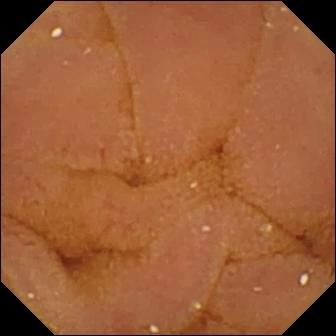

In [ ]:
PIL.Image.open(img_list[1])

In [ ]:
class TestData(Dataset):
    def __init__(self, dataframe, transform, use_preprocess = True):
        super().__init__()
        self.dataframe = dataframe
        self.transform = transform
        self.use_preprocess = use_preprocess
    
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, item):
      img_id = self.dataframe.iloc[item]['filename']
      img_path = os.path.join(test_images,img_id)
      
      if self.use_preprocess:
         image = preProcess_Image(img_path)
      if self.transform is not None:
        image = Image.open(img_path).convert('RGB')
        image = np.asarray(image)
        image = self.transform(image = image)['image']

      return image

## Build Classifier

In [ ]:
class CNN_Classifier(nn.Module):
    def __init__(self, model_name, pretrained = True):
        super().__init__()
        self.cnn = timm.create_model(model_name = model_name, pretrained=pretrained)
        self.classifier = nn.Sequential(nn.Dropout(0.1),
                                    nn.LeakyReLU(),
                                    nn.Linear(1000,num_classes))
        
    def forward(self, x):
        output = self.cnn(x)
        output = self.classifier(output)
        return output

## Build DataModule

In [ ]:
class DataModule(pl.LightningDataModule):

    def __init__(self, fold: int, train_batch_size: int, valid_batch_size: int, one_hot: bool = False):
        super().__init__()
        self.fold = fold
        self.train_batch_size = train_batch_size
        self.valid_batch_size = valid_batch_size
        self.one_hot = one_hot
        self.train_transform = train_aug
        self.valid_transform = val_aug

    def setup(self, stage: str = None):
        df_train = dfx[dfx.kfold != self.fold].reset_index(drop=True)
        df_valid = dfx[dfx.kfold == self.fold].reset_index(drop=True)

        df_train = df_train.reset_index(drop=True)
        df_valid = df_valid.reset_index(drop=True)

        self.train_dataset = Data(
            dataframe = df_train,
            transform = self.train_transform,
            one_hot = self.one_hot,
            use_preprocess = use_preprocess
        )

        self.valid_dataset = Data(
            dataframe = df_valid,
            transform = self.valid_transform,
            one_hot = self.one_hot,
            use_preprocess = use_preprocess
        )     

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.train_batch_size, shuffle = True, pin_memory = True, num_workers = 4, drop_last=True)
      
    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size = self.valid_batch_size, shuffle = False, pin_memory = True, num_workers = 4, drop_last=True)

## Lightning Module

In [ ]:
class CNNModule(pl.LightningModule):
    def __init__(self, model_name, learning_rate = 1e-4, use_scheduler = True, pretrained = True):
        super().__init__()

        self.net = CNN_Classifier(model_name, pretrained = pretrained)

        self.loss_function = nn.BCEWithLogitsLoss()
        self.learning_rate = learning_rate
        self.use_scheduler = use_scheduler
        self.save_hyperparameters()

        self.train_metric = tm.Accuracy()
        self.valid_metric = tm.Accuracy()

    def forward(self, x):
        output = self.net(x)
        return output

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=weight_decay)
        #lr_scheduler = {
        #"scheduler":torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        #        optimizer, T_0=5, T_mult=1, eta_min=1e-6, last_epoch=-1, verbose = True
        #    ),
        #"name":"CosineAnnealingWarmRestarts",
        #}

        # lr_scheduler = {
        # "scheduler":torch.optim.lr_scheduler.OneCycleLR(optimizer, 1e-4, total_steps=None, epochs=10, steps_per_epoch=len(self.train_dataloader()), pct_start=0.3, 
        #                                                 anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, 
        #                                                 final_div_factor=10000.0, three_phase=False, last_epoch=-1, verbose=True),
        # "name":"OneCycleLR",
        # "interval":"step"
        # }

        lr_scheduler = {
         "scheduler":torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, 
                                                                 threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08, verbose = True),
         "name":"ReduceLROnPlateau",
         "monitor":"Validation_loss_epoch",
         "interval":"epoch"
          }

        # lr_scheduler = {
        # "scheduler":torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=  [3,7], gamma=0.1, last_epoch=-1, verbose=True),
        # "name":"MultiStepLR",
        # }

        if self.use_scheduler:
              return [optimizer], [lr_scheduler]
        else:
              return optimizer

    def training_step(self, batch, batch_idx):
        image, targets = batch
        y_pred = self.forward(image)
        loss = self.loss_function(y_pred, targets.type_as(y_pred))
        train_acc_batch = self.train_metric(torch.sigmoid(y_pred), targets)
        self.log('train_acc_batch', train_acc_batch, prog_bar = True)
        self.log('train_loss_batch', loss)
        return {
            'loss': loss,
            'train_acc_batch': train_acc_batch,
        }

    def training_epoch_end(self, outputs):
        current_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
        current_train_acc = self.train_metric.compute()
        self.log('Training_loss_epoch', current_train_loss)
        self.log('Training_ACC_epoch', current_train_acc)

    def validation_step(self, batch, batch_idx):
        image, targets = batch
        y_pred = self.forward(image)
        loss = self.loss_function(y_pred, targets.type_as(y_pred))
        val_acc_batch = self.valid_metric(torch.sigmoid(y_pred), targets)
        self.log('val_acc_batch', val_acc_batch)
        self.log('val_loss_batch', loss)
        return {
          'val_loss': loss,
          'val_acc_batch': val_acc_batch
          }

    def validation_epoch_end(self, outputs):
        current_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        current_val_acc = self.valid_metric.compute()
        print(f"Epoch {self.current_epoch}: Loss: {current_val_loss:4f}: Acc:{current_val_acc:4f}")
        self.log("Validation_loss_epoch", current_val_loss)
        self.log('Validation_ACC_epoch', current_val_acc)

## Test the Dataset class defined for training data

In [ ]:
t  = Data(dataframe = dfx,
            transform = train_aug,
            one_hot = False,
            use_preprocess = use_preprocess
        )

In [ ]:
t.__len__()

37776

In [ ]:
t.__getitem__(1)

(tensor([[[ 0.7933,  0.7762,  0.7762,  ..., -2.1008, -2.1008, -2.1179],
          [ 0.8104,  0.8104,  0.7933,  ..., -2.1008, -2.1008, -2.1179],
          [ 0.8447,  0.8447,  0.8104,  ..., -2.1008, -2.1008, -2.1008],
          ...,
          [ 0.8961,  0.8961,  0.9132,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.8789,  0.8789,  0.8961,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.8447,  0.8447,  0.8447,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-0.0924, -0.0924, -0.0924,  ..., -2.0182, -2.0182, -2.0357],
          [-0.0574, -0.0574, -0.0749,  ..., -2.0182, -2.0357, -2.0357],
          [-0.0224, -0.0224, -0.0574,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [ 0.0301,  0.0476,  0.0651,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.0126,  0.0126,  0.0301,  ..., -2.0357, -2.0357, -2.0357],
          [-0.0224, -0.0224, -0.0224,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-0.6541, -0.6541, -0.6715,  ..., -1.8044, -1.8044, -1.8044],
          [-0.6541, -0.6715,

In [ ]:
test = TestData(dataframe = test_data, transform = val_aug, use_preprocess = True)

In [ ]:
test.__len__()

9448

In [ ]:
test.__getitem__(1)

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

## We can use Binary Cross Entropy for multiclass classification .

Each of your classes need to have a sigmoid output which makes each prediction independent of other classes. there you can use binary cross entropy to calculate the overall error/loss.

In [ ]:
dfx.head()

label                                         image_path  kfold
0      9  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...      0
1      9  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...      0
2      7  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...      0
3      9  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...      0
4      9  /content/drive/MyDrive/dphi/Kvasir/The Kvasir-...      0

In [ ]:
dm = DataModule(fold = 0, train_batch_size =32, valid_batch_size=16, one_hot = True)
    

In [ ]:
dm.setup()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


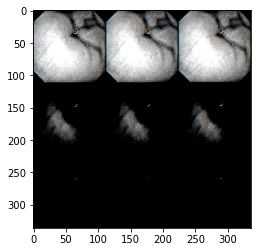

In [ ]:
for x,y in dm.train_dataloader():
  plt.imshow(x[0].reshape(336,336,3))
  break

In [ ]:
os.path.join(model_folder,model_name )

'/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/models/densenet121'

In [ ]:
import gc

In [ ]:
def run(fold):

    print(f"Running Fold-{fold}")


    check_path = os.path.join(model_folder,model_name,str(fold) )

    checkpointer = ModelCheckpoint(
    monitor = 'Validation_loss_epoch',
    dirpath = check_path,
    filename =  f"{model_name}" + "-{epoch:02d}-{Validation_loss_epoch:2f}",
    mode = 'min',
    save_top_k = 1,
    save_weights_only = True,
    verbose = True
    )

    early_stopping = EarlyStopping(
    monitor = 'Validation_loss_epoch',
    patience = 5,
    mode = 'min',
    verbose = True
    )

    learning_rate_monitor = LearningRateMonitor(logging_interval = 'epoch')

    callbacks = [checkpointer, 
                 early_stopping, 
                 learning_rate_monitor,
                 ]
    
    
    model = CNNModule(model_name = model_name, 
                      learning_rate=lr, 
                      pretrained = pretrained)
    
    dm = DataModule(fold = fold, 
                    train_batch_size = batch_size_train, 
                    valid_batch_size=batch_size_val, one_hot = True)
    
    trainer = pl.Trainer(
    callbacks = callbacks,
    max_epochs = 3,
    #max_epochs = 1,
    auto_lr_find=True,
    progress_bar_refresh_rate = 5,
    accumulate_grad_batches=int(virtual_batch_size/batch_size_train),
    gpus = 1,
    precision = 16,
    move_metrics_to_cpu = True 
    )

    #trainer.tune(model, dm)
    trainer.fit(model,dm)
    del model
    torch.cuda.empty_cache()
    gc.collect()

## densenet121- run 0

In [ ]:
run(0)

Running Fold-0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | net           | CNN_Classifier    | 8.0 M 
1 | loss_function | BCEWithLogitsLoss | 0     
2 | train_metric  | Accuracy          | 0     
3 | valid_metric  | Accuracy          | 0     
----------------------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params
31.971    Total estimated model params size (MB)


Epoch 0: Loss: 0.720824: Acc:0.524554


In [ ]:
run(1)

Running Fold-1


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | net           | CNN_Classifier    | 8.0 M 
1 | loss_function | BCEWithLogitsLoss | 0     
2 | train_metric  | Accuracy          | 0     
3 | valid_metric  | Accuracy          | 0     
----------------------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params
31.971    Total estimated model params size (MB)


Epoch 0: Loss: 0.734054: Acc:0.488839


https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538

https://pytorch-lightning.readthedocs.io/en/stable/advanced/lr_finder.html

## Building Inference

In [ ]:
class CONFIG_INFERENCE():
  test_images = "/content/KneeXray/test"
  testset = "/content/KneeXray/sample_submission.csv"

  model_paths = [
                 '/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/0/resnext50_32x4d-epoch=02-Validation_loss_epoch=0.283553.ckpt',
                 '/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/1/resnext50_32x4d-epoch=03-Validation_loss_epoch=0.280259.ckpt',
                 '/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/2/resnext50_32x4d-epoch=02-Validation_loss_epoch=0.285458.ckpt',
                 '/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/3/resnext50_32x4d-epoch=02-Validation_loss_epoch=0.284261.ckpt',
                 '/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/4/resnext50_32x4d-epoch=02-Validation_loss_epoch=0.282668.ckpt'
                 ]


  batch_size = 32

  device = ('cuda' if torch.cuda.is_available() else 'cpu')

#instantiate the class(object)
cfg_inference = CONFIG_INFERENCE()

## Test data augmentation

In [ ]:
test_aug = albumentations.Compose([
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ), ToTensorV2(),
])

## Prepare Test Dataset

In [ ]:
dfx_test = test_data.copy()
test_dataset = TestData(dataframe=dfx_test, transform=test_aug)
test_dataloader = DataLoader(test_dataset, batch_size=cfg_inference.batch_size, shuffle = False)

## Function to load the weights of the trained model

In [ ]:
def load_model(path):
  w = torch.load(path, map_location=cfg_inference.device)
  m = CNNModule(model_name = cfg.model_name, pretrained = False)
  m.load_state_dict(w['state_dict'])
  return m.net

## Make Predictions -  average of all the results from 5 different folds

In [ ]:
from tqdm import tqdm
final_preds = None
for path in cfg_inference.model_paths:
  model = load_model(path)
  model.to(cfg_inference.device)
  temp_preds = None
  model.eval()
  for batch in tqdm(test_dataloader):
    images = batch.to(cfg_inference.device)
    preds = torch.sigmoid(model(images)).cpu().detach().numpy()
    if temp_preds is None:
        temp_preds = preds
    else:
        temp_preds = np.vstack((temp_preds, preds))
  
  if final_preds is None:
      final_preds = temp_preds
  else:
      final_preds += temp_preds
final_preds /= len(cfg_inference.model_paths)